# Generative Adversarial Network State Tomography Demo

Quantum State Tomography (QST) using a generative adversarial network (GAN).

## Install libraries to runtime

If running in Google Colab, run the following setup cell once each time you open your project in order to install non-default package dependencies to the runtime. DO NOT RUN if you have already created a kernel with `qsttoolkit` as per the setup instructions in `README.md`.

In [ ]:
!pip install qsttoolkit

## Imports

All of QSTToolkit's features can be accessed by importing `qsttoolkit` and calling them directly. Most features sit within two main subpackages: `.data` and `.tomography`. In this example notebook, functions are called from their subpackage where relevant to show which features sit in each subpackage, and which lie in modules outside either:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
import tensorflow as tf
import qsttoolkit as qst

## Data Preparation

We start by defining the Hilbert space dimensionality of our system as `dim`, and the phase space grid for our measurement data - the Husimi Q representation of a state in phase space. This grid is defined to be `data_dim` x `data_dim`:

In [3]:
dim = 32
data_dim = 32                 # Dimensions of the phase space grid that will serve as the image size for our data
xgrid = np.linspace(-5, 5, data_dim)
pgrid = np.linspace(-5, 5, data_dim)

We first create test state density matrices of seven different varieties using the [QuTiP](https://qutip.org/docs/4.0.2/index.html) framework. The first three states can be produced directly using QuTiP functions, the other four are specific superpositions of Fock and coherent states and are produced using custom functions in `qsttoolkit.data`:

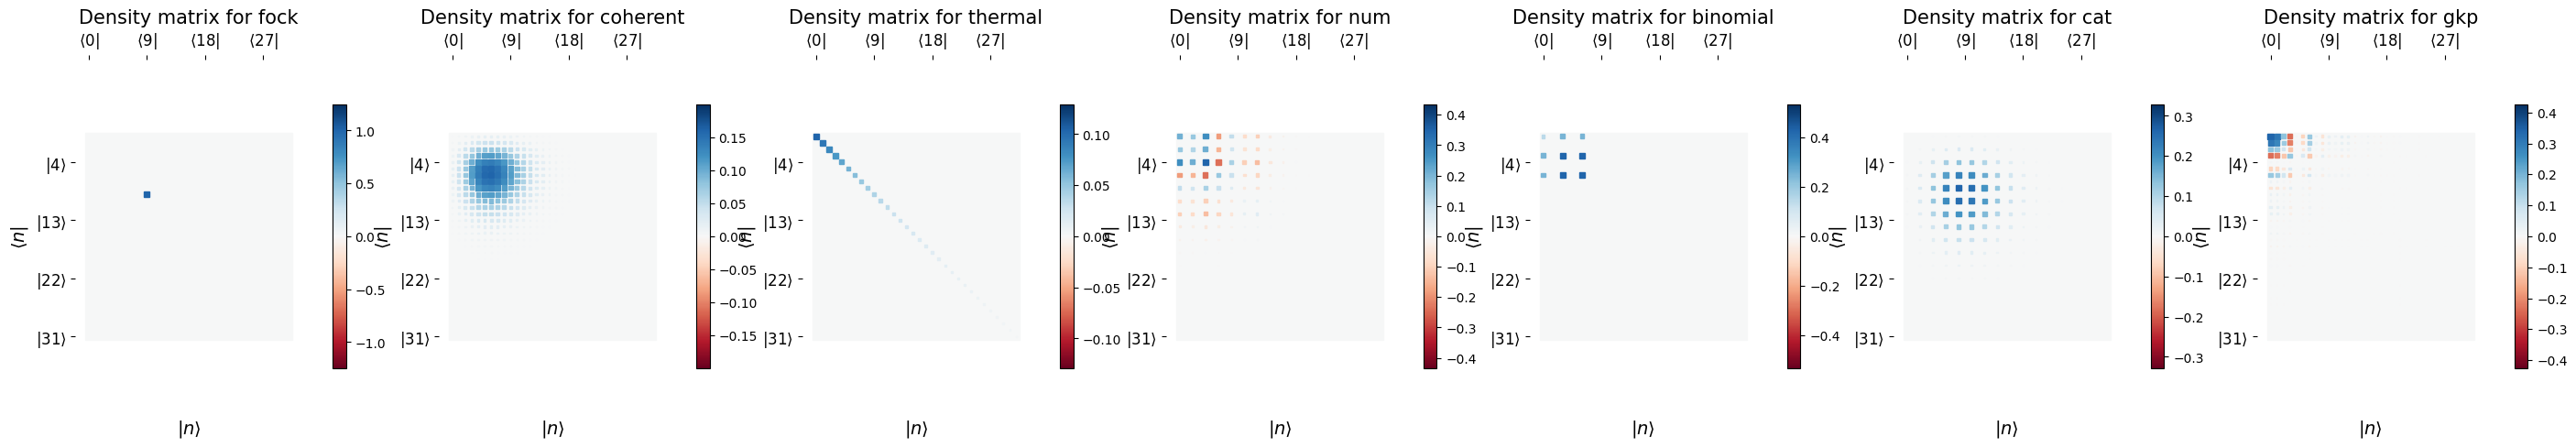

In [4]:
fock_test = qt.fock_dm(dim, 9)
coherent_test = qt.coherent_dm(dim, 2.5)
thermal_test = qt.thermal_dm(dim, 9)
num_test = qst.data.num_dm('M2', dim)
binomial_test = qst.data.binomial_dm(dim, 2, 2, 1)
cat_test = qst.data.cat_dm(dim, 3)
gkp_test = qst.data.gkp_dm(dim, [-5, 5], [-5, 5], 0.5, 4.5)

fig, ax = plt.subplots(1, 7, figsize=(35, 5))
qst.plot_hinton(fock_test, ax=ax[0], label='fock')
qst.plot_hinton(coherent_test, ax=ax[1], label='coherent')
qst.plot_hinton(thermal_test, ax=ax[2], label='thermal')
qst.plot_hinton(num_test, ax=ax[3], label='num')
qst.plot_hinton(binomial_test, ax=ax[4], label='binomial')
qst.plot_hinton(cat_test, ax=ax[5], label='cat')
qst.plot_hinton(gkp_test, ax=ax[6], label='gkp')
plt.show()

We create the measurement operators for heterodyne detection of quantum states using `qsttoolkit.data.measurement_operators()`:

In [5]:
measurement_operators = qst.data.measurement_operators(dim, 'heterodyne', xgrid=xgrid, pgrid=pgrid)

We choose our test state and apply mixed state noise, and then create the POVM expectation probabilities for our given measurement regime:

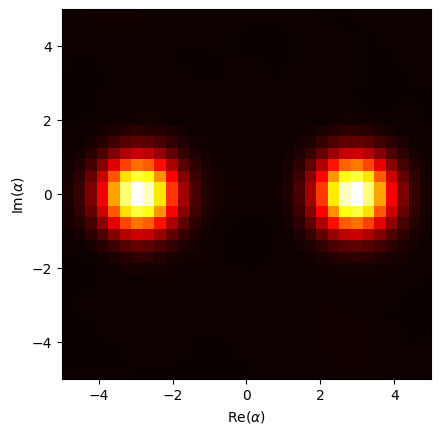

In [ ]:
test_state = qst.data.mixed_state_noise(cat_test, 0.2)
expectation_values = qst.expectation(test_state, measurement_operators, numpy=True)
expectation_values /= np.sum(expectation_values)                                # Normalize to create valid probabilities

plt.imshow(expectation_values.reshape(data_dim, data_dim), extent=[-5, 5, -5, 5],cmap='hot')
plt.xlabel("Re($\\alpha$)")
plt.ylabel("Im($\\alpha$)")
plt.show()

We then sample our finite measurement shots of the state:

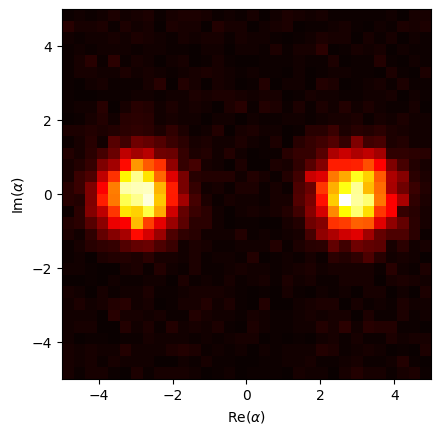

In [7]:
measurement_data = qst.data.measure_shots(expectation_values, num_shots=10000)

plt.imshow(measurement_data.reshape(data_dim, data_dim), extent=[-5, 5, -5, 5],cmap='hot')
plt.xlabel("Re($\\alpha$)")
plt.ylabel("Im($\\alpha$)")
plt.show()

## Modelling

We create an instance of the `qsttoolkit.tomography.GANQuantumStateTomography` class, which handles the model architecture, compiling and training:

In [8]:
GAN_reconstructor = qst.tomography.GANQuantumStateTomography(data_dim=data_dim**2)

Training the generator adversarially to learn to reconstruct the test density matrix from measurements using the `.reconstruct` method:

In [10]:
import logging
tf.get_logger().setLevel(logging.ERROR)     # Suppress TensorFlow warnings that can occur in some environments

GAN_reconstructor.reconstruct(measurement_data,
                              measurement_operators,
                              epochs=500,
                              verbose_interval=50,
                              num_progress_saves=10,        # Save the progress of the training
                              true_dm=test_state)           # For calculating the fidelity of the reconstructed during training

Epoch 0/500, Generator Loss: 0.6919275522232056, Discriminator Loss: 0.6933023929595947, Fidelity: 0.31478947076053215
Epoch 50/500, Generator Loss: 0.6894623637199402, Discriminator Loss: 0.6736737489700317, Fidelity: 0.14860187836815703
Epoch 100/500, Generator Loss: 0.695124626159668, Discriminator Loss: 0.67542564868927, Fidelity: 0.4213811084388343
Epoch 150/500, Generator Loss: 0.7854502201080322, Discriminator Loss: 0.6064514517784119, Fidelity: 0.4332863114488952
Epoch 200/500, Generator Loss: 0.6378886103630066, Discriminator Loss: 0.6730657815933228, Fidelity: 0.5171398545239948
Epoch 250/500, Generator Loss: 0.8010761141777039, Discriminator Loss: 0.633890688419342, Fidelity: 0.6750690174318207
Epoch 300/500, Generator Loss: 0.8269470930099487, Discriminator Loss: 0.5255193710327148, Fidelity: 0.20291598749698905
Epoch 350/500, Generator Loss: 0.837379515171051, Discriminator Loss: 0.5299032926559448, Fidelity: 0.7501538763800762
Epoch 400/500, Generator Loss: 0.621513128280

## Analysis

Model statistics over training progress:

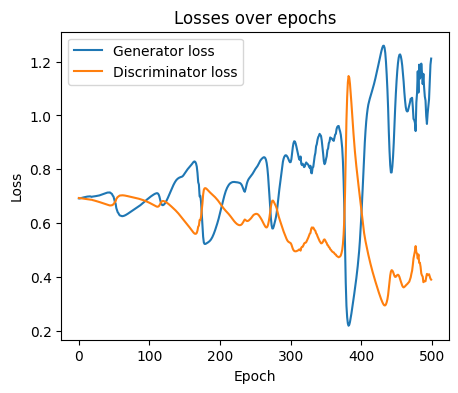

In [11]:
GAN_reconstructor.plot_losses()

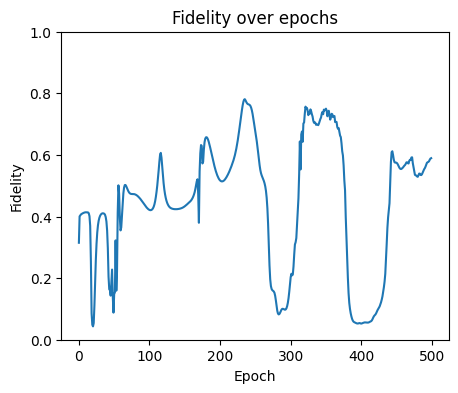

In [12]:
GAN_reconstructor.plot_fidelities()

Comparison of the true and reconstructed states:

In [13]:
print(f"State fidelity: {qst.fidelity(test_state, GAN_reconstructor.reconstructed_dm)}")

State fidelity: 0.5887682733167855


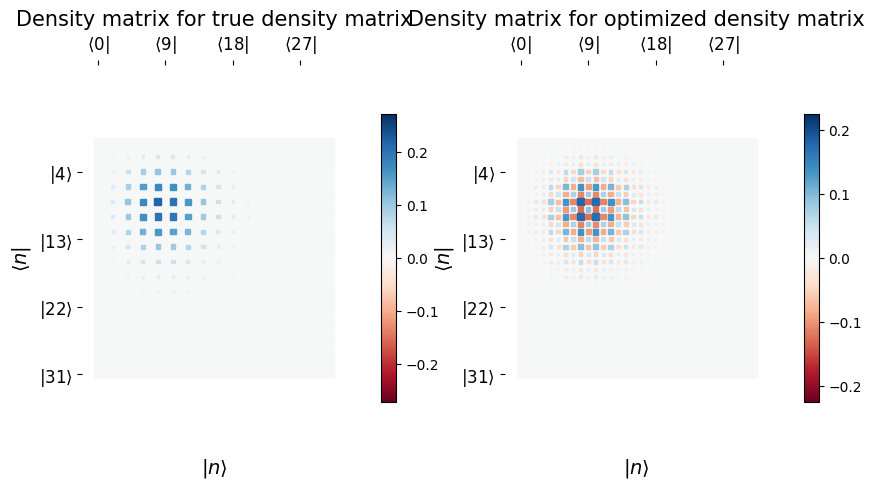

In [14]:
GAN_reconstructor.plot_comparison_hintons(test_state)

Comparison of the original test data, and data sampled from the reconstructed state:

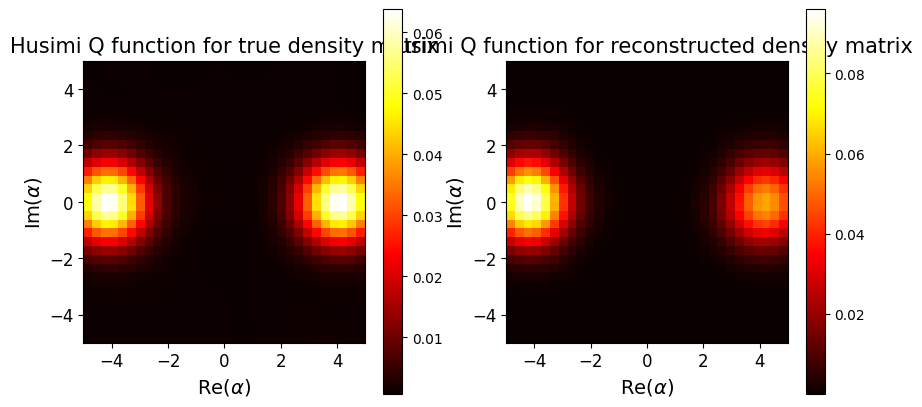

In [15]:
GAN_reconstructor.plot_comparison_husimi_Qs(test_state, xgrid, pgrid)

Inspection of reconstructions from intermediate parametrizations during optimisation:

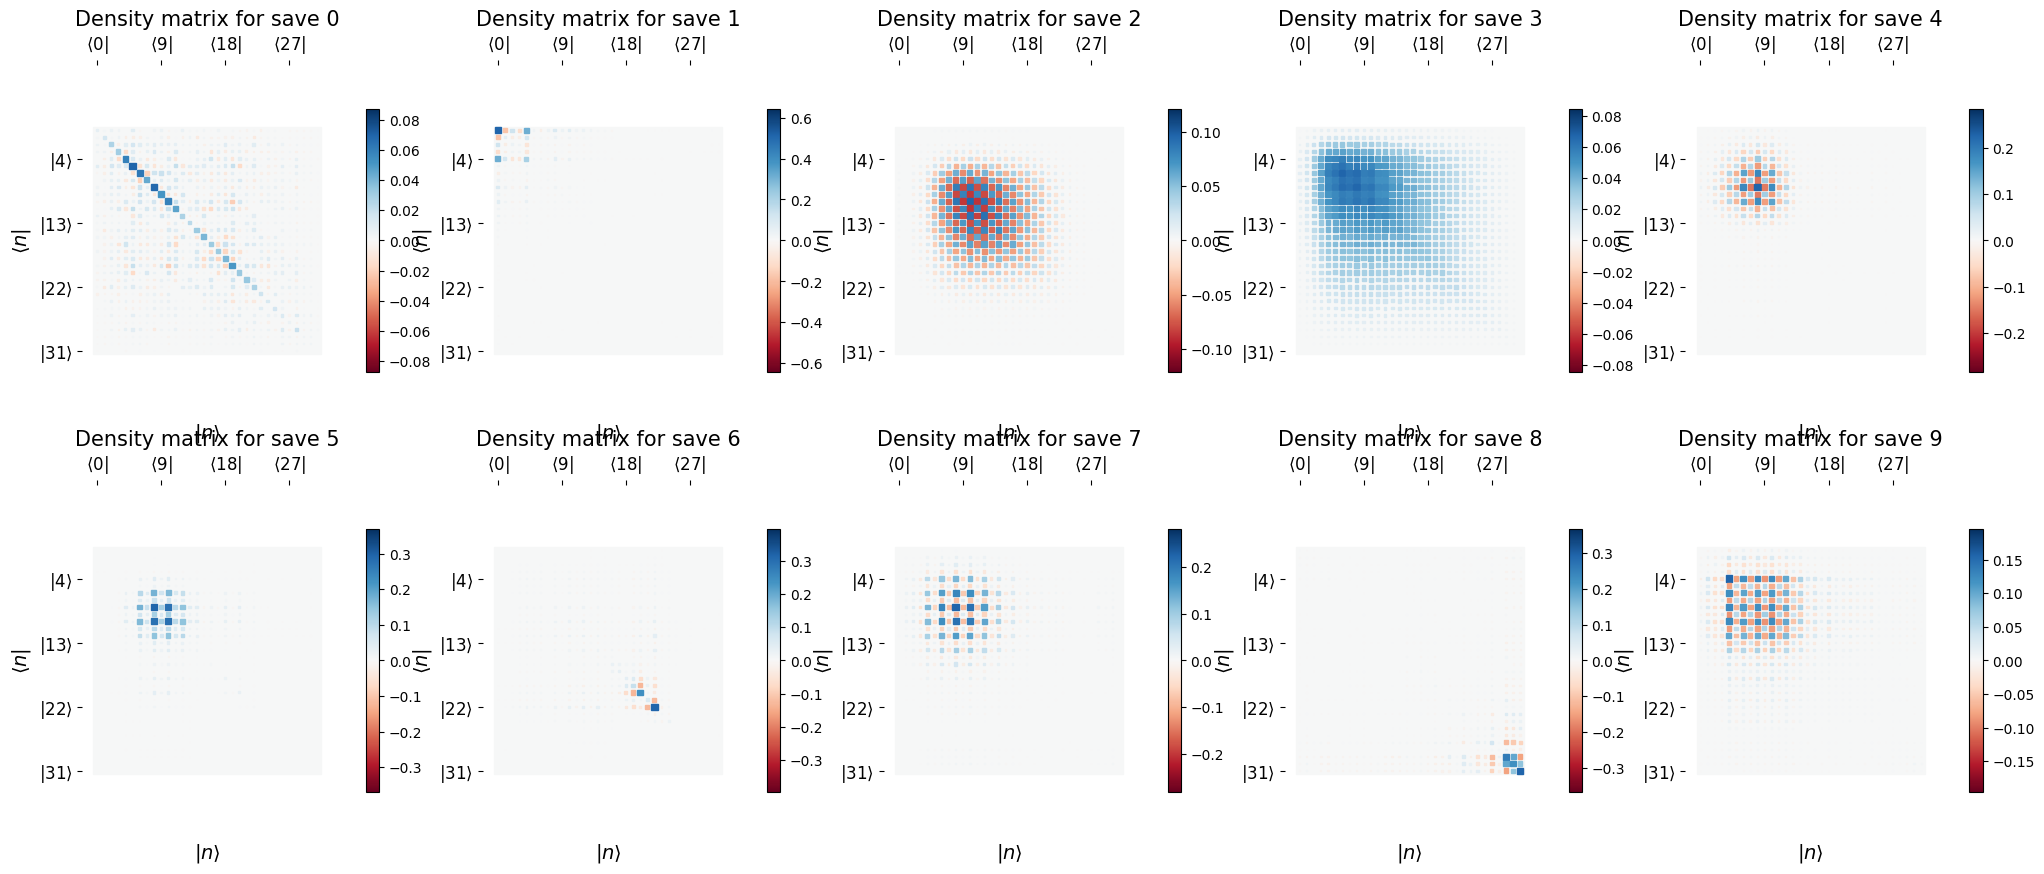

In [16]:
GAN_reconstructor.plot_intermediate_hintons()

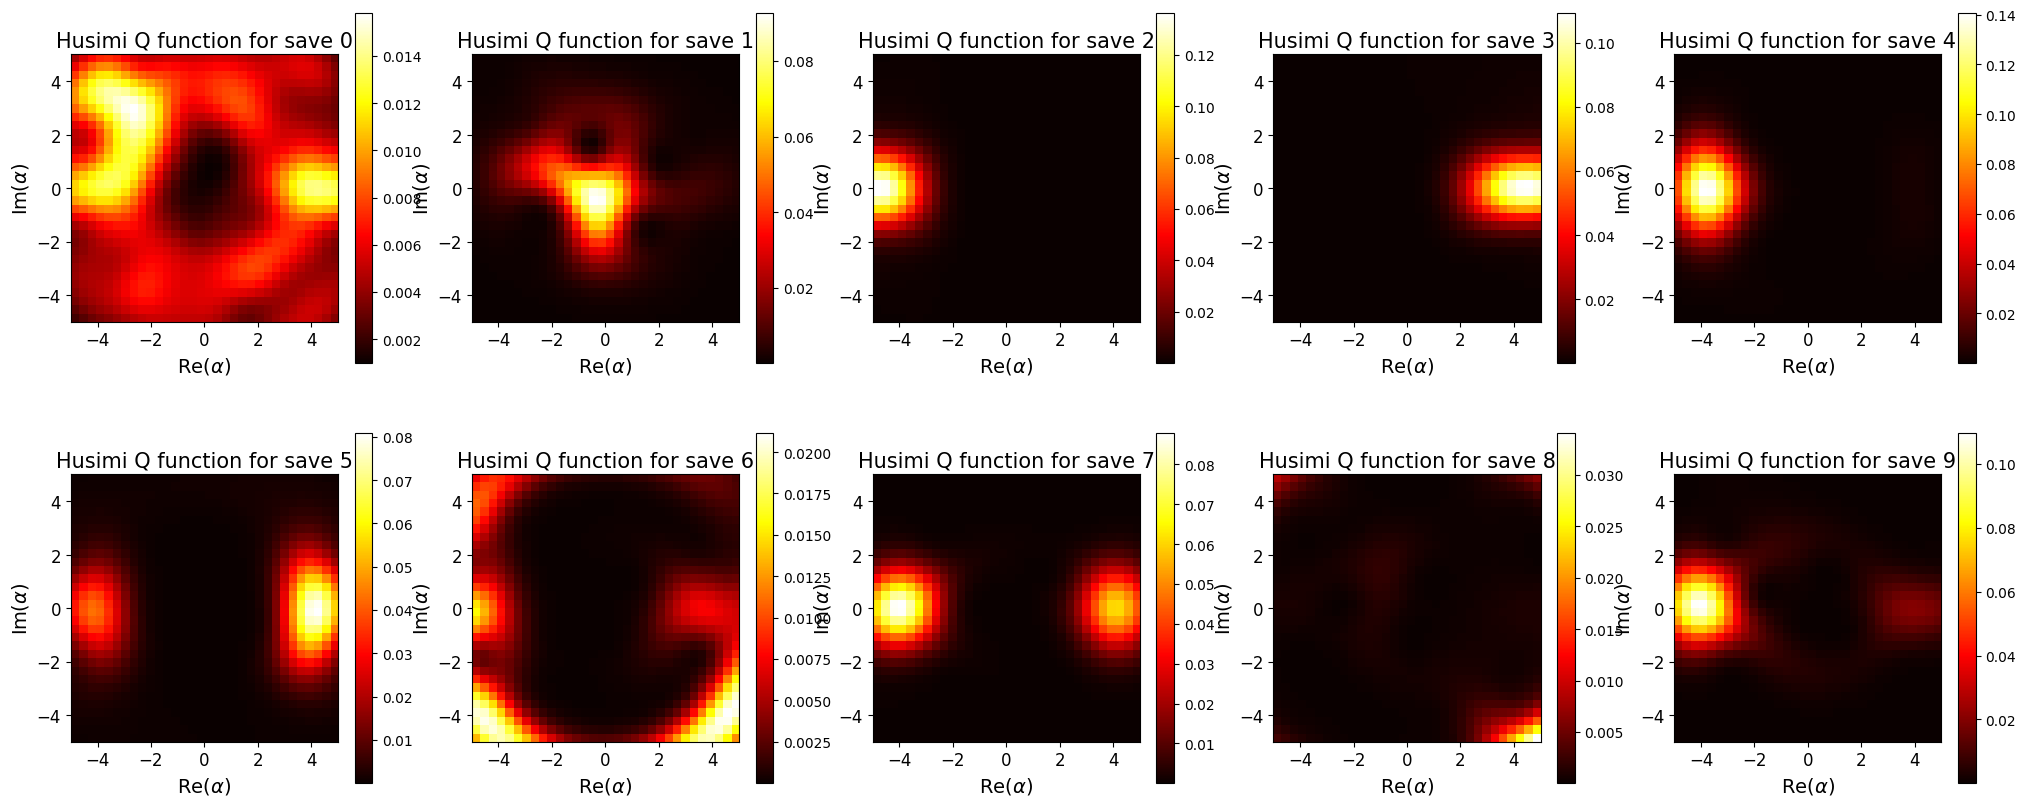

In [22]:
GAN_reconstructor.plot_intermediate_husimi_Qs(xgrid, pgrid)

GANs train to find a balance between the performance of the generator and discriminator models. The plot below displays the fidelity between the true and reconstructed states for each point in the generator/discriminator loss space over the training:

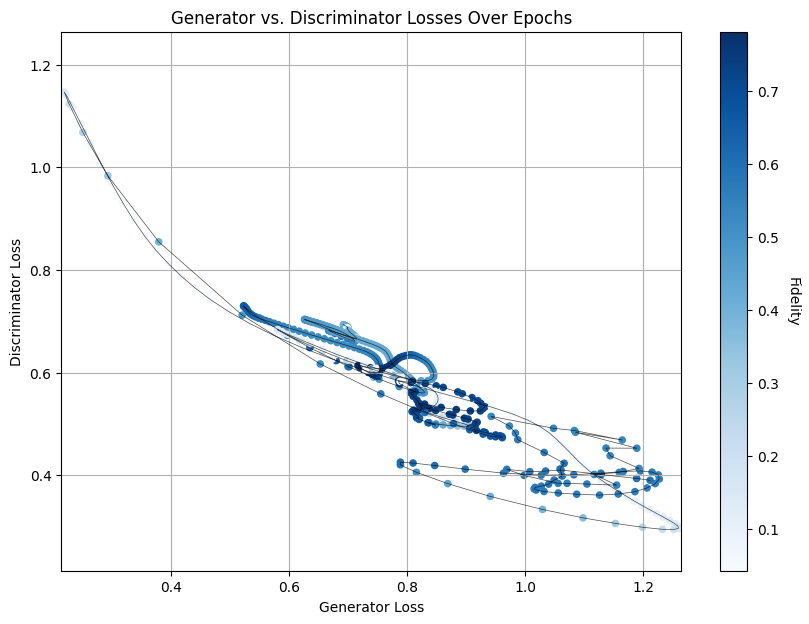

In [18]:
GAN_reconstructor.plot_loss_space()

`GANQuantumStateTomography.generator` and `GANQuantumStateTomography.discriminator` can be treated as `tensorflow.keras.Model` objects, for example:

In [21]:
GAN_reconstructor.generator.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_vector_input (InputLayer)  │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 16, 16, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 32, 32, 64)     │         2,112 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 64)     │        65,600 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │        32,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 32, 32, 2)      │         1,026 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cholesky_lower_triangular       │ (None, 32, 32, 2)      │             0 │
│ (CholeskyLowerTriangular)       │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 626,850 (2.39 MB)

 Trainable params: 626,594 (2.39 MB)

 Non-trainable params: 256 (1.00 KB)

In [20]:
GAN_reconstructor.discriminator.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_vector_input (InputLayer)  │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 141,569 (553.00 KB)

 Trainable params: 141,569 (553.00 KB)

 Non-trainable params: 0 (0.00 B)